In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# os.getcwd()

In [ ]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
# !pip install kaggle

In [ ]:
# os.chdir('/content/drive/MyDrive/gdrive')

In [ ]:
# !kaggle datasets download -d vishakudupa/fake-job

In [ ]:
# os.listdir()

In [ ]:
# zip_path = '/content/drive/MyDrive/gdrive/fake-job.zip'

In [ ]:
# !cp {'zip_path' , '/content/drive/MyDrive/gdrive/fake_job_classifier'}

In [ ]:
# !unzip -q 'fake-job.zip'

In [ ]:
import os
os.chdir('/content/drive/MyDrive/gdrive/fake_job_classifier')

In [ ]:
os.listdir()

['fake_job.txt',
 'fake_job_test.csv',
 'fake_job_train.csv',
 'fake_job_classifier.h5']

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df_train = pd.read_csv('fake_job_train.csv')
df_test = pd.read_csv('fake_job_test.csv')

In [ ]:
df_train.head()

,description,fraudulent
0,We have aggressive growth plans in place for t...,1
1,VACANCY: Support Worker (Personal Assistant) ...,0
2,Need a change? Looking for growth opportunity?...,0
3,Do you have what it takes to cultivate the nex...,0
4,"UFN prides itself on creating an engaging, cre...",0


In [ ]:
df_test.head()

,description,fraudulent
0,Experienced Process Control Engineer is requir...,0
1,Growth Intelligence is a pioneer of nowcasting...,0
2,MERL is looking for a highly motivated intern ...,0
3,Coordinate timely closing of mortgage loan app...,0
4,Are you looking for an exciting new position a...,0


In [ ]:
df_train.shape

(14304, 2)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  14303 non-null  object
 1   fraudulent   14304 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 223.6+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  3576 non-null   object
 1   fraudulent   3576 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.0+ KB


In [ ]:
df_train = df_train.dropna()

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df

,description,fraudulent
0,We have aggressive growth plans in place for t...,1
1,VACANCY: Support Worker (Personal Assistant) ...,0
2,Need a change? Looking for growth opportunity?...,0
3,Do you have what it takes to cultivate the nex...,0
4,"UFN prides itself on creating an engaging, cre...",0
...,...,...
17874,EROAD is looking for an additional member for ...,0
17875,Government funding is only available for 16-18...,0
17876,Are you looking for something a little differe...,0
17877,Key Duties:• Rough cut shows on Adobe Premier ...,0


In [ ]:
X = df['description']

In [ ]:
y = df['fraudulent']

In [ ]:
X

0        We have aggressive growth plans in place for t...
1        VACANCY:  Support Worker (Personal Assistant) ...
2        Need a change? Looking for growth opportunity?...
3        Do you have what it takes to cultivate the nex...
4        UFN prides itself on creating an engaging, cre...
                               ...                        
17874    EROAD is looking for an additional member for ...
17875    Government funding is only available for 16-18...
17876    Are you looking for something a little differe...
17877    Key Duties:• Rough cut shows on Adobe Premier ...
17878    HRdownloads, Canada’s fastest growing Human Re...
Name: description, Length: 17879, dtype: object

In [ ]:
y

0        1
1        0
2        0
3        0
4        0
        ..
17874    0
17875    0
17876    0
17877    0
17878    0
Name: fraudulent, Length: 17879, dtype: int64

In [ ]:
print(df['fraudulent'].unique())

[1 0]


In [ ]:
y.shape

(17879,)

In [ ]:
X.shape

(17879,)

In [ ]:
from keras.utils import to_categorical
y = np.array(y)

y_encoded = to_categorical(y, num_classes=2)

In [ ]:
y_encoded

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
y_encoded.shape

(17879, 2)

In [ ]:
MAX_FEATURES = 200000

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y_encoded))
dataset = dataset.cache()
dataset = dataset.shuffle(10000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(2, activation='sigmoid'))

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                          

In [ ]:
# hist = model.fit(train, epochs=20, validation_data=val,callbacks=[reduce_lr, early_stopping])

Epoch 1/20
782/782 [==============================] - 183s 219ms/step - loss: 0.1583 - accuracy: 0.9596 - val_loss: 0.3214 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 2/20
782/782 [==============================] - 95s 121ms/step - loss: 0.0718 - accuracy: 0.9808 - val_loss: 0.1914 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/20
782/782 [==============================] - 83s 105ms/step - loss: 0.0398 - accuracy: 0.9887 - val_loss: 0.0738 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 4/20
782/782 [==============================] - 80s 103ms/step - loss: 0.0248 - accuracy: 0.9932 - val_loss: 0.1857 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 5/20
782/782 [==============================] - 77s 98ms/step - loss: 0.0180 - accuracy: 0.9957 - val_loss: 0.0264 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 6/20
782/782 [==============================] - 77s 98ms/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.0398 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 7/20
782/782 [==============================] -

<Figure size 800x500 with 0 Axes>

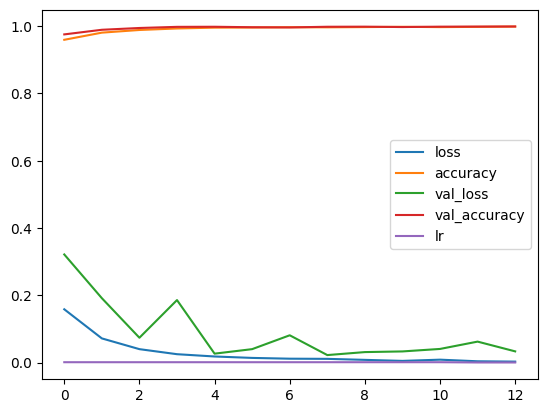

In [ ]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(8,5))
# pd.DataFrame(hist.history).plot()
# plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
# pre = Precision()
# re = Recall()
# acc = CategoricalAccuracy()

In [ ]:
# for batch in test.as_numpy_iterator():
#     # Unpack the batch
#     X_true, y_true = batch
#     # Make a prediction
#     yhat = model.predict(X_true, batch_size=32)

#     # Flatten the predictions
#     y_true = y_true.flatten()
#     yhat = yhat.flatten()
#     print(yhat.shape, y_true.shape)

#     pre.update_state(y_true, yhat)
#     re.update_state(y_true, yhat)
#     acc.update_state(y_true, yhat)

1/1 [==============================] - 1s 687ms/step
(32,) (32,)
1/1 [==============================] - 0s 60ms/step
(32,) (32,)
1/1 [==============================] - 0s 62ms/step
(32,) (32,)
1/1 [==============================] - 0s 60ms/step
(32,) (32,)
1/1 [==============================] - 0s 57ms/step
(32,) (32,)
1/1 [==============================] - 0s 61ms/step
(32,) (32,)
1/1 [==============================] - 0s 56ms/step
(32,) (32,)
1/1 [==============================] - 0s 55ms/step
(32,) (32,)
1/1 [==============================] - 0s 54ms/step
(32,) (32,)
1/1 [==============================] - 0s 52ms/step
(32,) (32,)
1/1 [==============================] - 0s 53ms/step
(32,) (32,)
1/1 [==============================] - 0s 54ms/step
(32,) (32,)
1/1 [==============================] - 0s 53ms/step
(32,) (32,)
1/1 [==============================] - 0s 58ms/step
(32,) (32,)
1/1 [==============================] - 0s 54ms/step
(32,) (32,)
1/1 [==============================] - 

In [ ]:
# print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9966216087341309, Recall:0.9966216087341309, Accuracy:0.06306306272745132


In [ ]:
# model.save('fake_job_classifier.h5')

In [ ]:
model = tf.keras.models.load_model('fake_job_classifier.h5')

In [ ]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 11.1 MB/s eta 0

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
from sqlalchemy import false
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    print(results)
    text = ''
    if results[0][0] > results[0][1]:
      text += '{}: {}\n'.format('fraudulent', False)
    else:
      text += '{}: {}\n'.format('fraudulent', True)
    return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='job description'),
                        outputs='text')

<ipython-input-82-e86d0856f4a8>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='job description'),
<ipython-input-82-e86d0856f4a8>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='job description'),
<ipython-input-82-e86d0856f4a8>:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='job description'),


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://40cbe428c7df5e4eb3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
